# Timeseries classification using LSTM

**Author:** [hfawaz](https://github.com/hfawaz/), [Vijay Yalamanchili](https://github.com/vijaykrishnay/)<br>
**Date created:** 2020/07/21<br>
**Last modified:** 2020/12/15<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.

## Introduction

This example shows how to do timeseries classification from scratch using LSTM, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [3]:
x_train

array([[-0.79717168, -0.66439208, -0.37301463, ..., -0.66439208,
        -1.0737958 , -1.5643427 ],
       [ 0.80485472,  0.63462859,  0.37347448, ..., -0.71488505,
        -0.56044294, -0.31908642],
       [ 0.7279851 ,  0.11128392, -0.49912439, ...,  0.39446303,
         0.33940042,  0.25539062],
       ...,
       [-0.57005428, -0.33316523, -0.29351853, ..., -1.3937145 ,
        -0.94273327, -0.27072168],
       [ 2.0067321 ,  2.0791499 ,  2.0220362 , ..., -0.43214504,
        -0.44123126, -0.28070891],
       [-0.12524091, -0.32536268, -0.48823697, ...,  0.55576053,
         0.57445102,  0.57311598]])

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

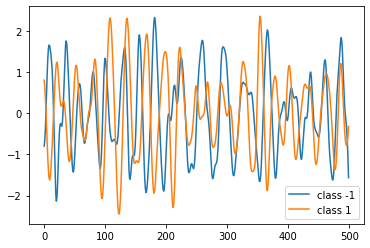

In [4]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (176). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [5]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [6]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [7]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [8]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a model using LSTM as the first later followed by a fully connected layer. Dropout layer is used for regularization.

The following hyperparameters (# of LSTM, dense units, dropout rate, learning rate, batch size, the usage of BatchNorm) were tuned to arrive at the below values. 

In [9]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    lstm1 = keras.layers.LSTM(24, return_sequences=False)(input_layer)
    lstm1 = keras.layers.BatchNormalization()(lstm1)
    lstm1 = keras.layers.Dropout(0.25)(lstm1)
    
    dense1 = keras.layers.Dense(8, activation="relu")(lstm1)
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(dense1)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 24)                2496      
_________________________________________________________________
batch_normalization (BatchNo (None, 24)                96        
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 2,810
Trainable params: 2,762
Non-trainable params: 48
__________________________________________________________

## Train the model

In [10]:
epochs = 500
batch_size = 32
learning_rate = 0.001
model_name = "best_model_lstm.h5"
rho = 0.9

callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_name, save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=15, min_lr=0.00005
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
]
model.compile(
    # RMSProp worked better than Adam solver for this problem, model setup.
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 7s 64ms/step - loss: 0.7578 - sparse_categorical_accuracy: 0.5165 - val_loss: 0.6953 - val_sparse_categorical_accuracy: 0.5090
Epoch 2/500
90/90 [==============================] - 5s 58ms/step - loss: 0.7200 - sparse_categorical_accuracy: 0.5035 - val_loss: 0.6949 - val_sparse_categorical_accuracy: 0.4993
Epoch 3/500
90/90 [==============================] - 5s 58ms/step - loss: 0.7083 - sparse_categorical_accuracy: 0.5162 - val_loss: 0.6953 - val_sparse_categorical_accuracy: 0.5076
Epoch 4/500
90/90 [==============================] - 5s 58ms/step - loss: 0.7206 - sparse_categorical_accuracy: 0.4918 - val_loss: 0.6965 - val_sparse_categorical_accuracy: 0.5076
Epoch 5/500
90/90 [==============================] - 5s 58ms/step - loss: 0.7055 - sparse_categorical_accuracy: 0.5084 - val_loss: 0.6946 - val_sparse_categorical_accuracy: 0.5049
Epoch 6/500
90/90 [==============================] - 5s 58ms/step - loss: 0.6991 - sparse_categorica

90/90 [==============================] - 5s 57ms/step - loss: 0.2028 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.1736 - val_sparse_categorical_accuracy: 0.9209
Epoch 92/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1768 - sparse_categorical_accuracy: 0.9375 - val_loss: 0.1722 - val_sparse_categorical_accuracy: 0.9362
Epoch 93/500
90/90 [==============================] - 5s 57ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.9198 - val_loss: 0.1854 - val_sparse_categorical_accuracy: 0.9404
Epoch 94/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1969 - sparse_categorical_accuracy: 0.9293 - val_loss: 0.1582 - val_sparse_categorical_accuracy: 0.9417
Epoch 95/500
90/90 [==============================] - 5s 57ms/step - loss: 0.2138 - sparse_categorical_accuracy: 0.9250 - val_loss: 0.1725 - val_sparse_categorical_accuracy: 0.9265
Epoch 96/500
90/90 [==============================] - 5s 58ms/step - loss: 0.2035 - sparse_categorical_accur

90/90 [==============================] - 5s 57ms/step - loss: 0.1520 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.1445 - val_sparse_categorical_accuracy: 0.9348
Epoch 182/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1415 - sparse_categorical_accuracy: 0.9465 - val_loss: 0.1372 - val_sparse_categorical_accuracy: 0.9445
Epoch 183/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1716 - sparse_categorical_accuracy: 0.9427 - val_loss: 0.1451 - val_sparse_categorical_accuracy: 0.9390
Epoch 184/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1756 - sparse_categorical_accuracy: 0.9368 - val_loss: 0.1358 - val_sparse_categorical_accuracy: 0.9459
Epoch 185/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1731 - sparse_categorical_accuracy: 0.9329 - val_loss: 0.1354 - val_sparse_categorical_accuracy: 0.9459
Epoch 186/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1446 - sparse_categorical_

90/90 [==============================] - 5s 57ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.1414 - val_sparse_categorical_accuracy: 0.9431
Epoch 272/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1583 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.1364 - val_sparse_categorical_accuracy: 0.9459
Epoch 273/500
90/90 [==============================] - 5s 58ms/step - loss: 0.1443 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.1381 - val_sparse_categorical_accuracy: 0.9445
Epoch 274/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1480 - sparse_categorical_accuracy: 0.9464 - val_loss: 0.1367 - val_sparse_categorical_accuracy: 0.9431
Epoch 275/500
90/90 [==============================] - 5s 58ms/step - loss: 0.1474 - sparse_categorical_accuracy: 0.9438 - val_loss: 0.1363 - val_sparse_categorical_accuracy: 0.9445
Epoch 276/500
90/90 [==============================] - 5s 57ms/step - loss: 0.1364 - sparse_categorical_

## Evaluate model on test data

In [11]:
model = keras.models.load_model(model_name)

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 16ms/step - loss: 0.1682 - sparse_categorical_accuracy: 0.9409
Test accuracy 0.9409090876579285
Test loss 0.16816461086273193


## Plot the model's training and validation loss

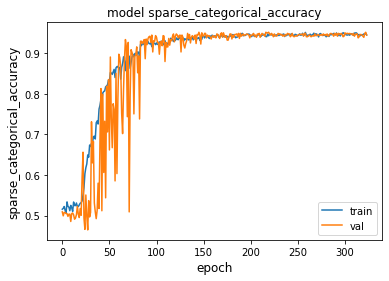

In [12]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

Training accuracy stabilizes around 200 epochs. Both Validation and test accuracy are very close to training accuracy indicating that the model generalizes well.